<a href="https://colab.research.google.com/github/joaovitorcg04/Sistema_de_Reconhecimento_Facial/blob/main/sistema_de_reconhecimento_facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mtcnn
!pip install tensorflow
!pip install scikit-learn

In [ ]:
import os
import cv2
import numpy as np
from mtcnn.mtcnn import MTCNN
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import pickle
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode


def data_to_image(js_reply):

    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

# Função para capturar uma foto da webcam
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capturar';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Redimensiona o output para caber na tela
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Aguarda o clique no botão
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    img = data_to_image(data)
    # Salva a imagem capturada
    cv2.imwrite(filename, img)
    return filename

Digite o nome da pessoa a ser cadastrada (sem espaços ou acentos): Joao_Vitor
Prepare-se para tirar 15 fotos de 'Joao_Vitor'. Varie as expressões e ângulos.
Capturando imagem 1/15...


<IPython.core.display.Javascript object>

Salvo como dataset/Joao_Vitor/0.jpg


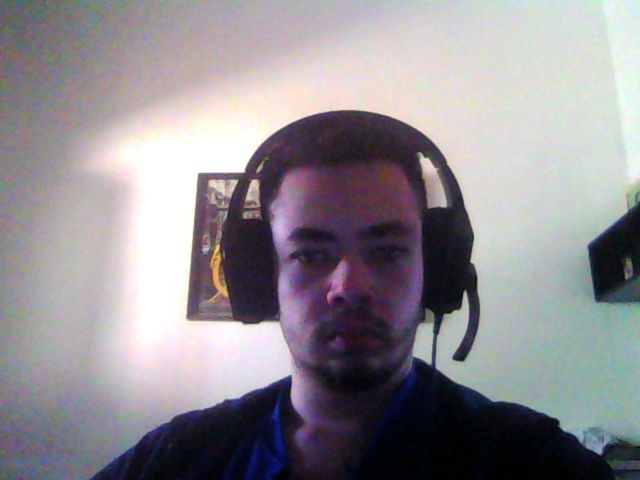

Capturando imagem 2/15...


<IPython.core.display.Javascript object>

Salvo como dataset/Joao_Vitor/1.jpg


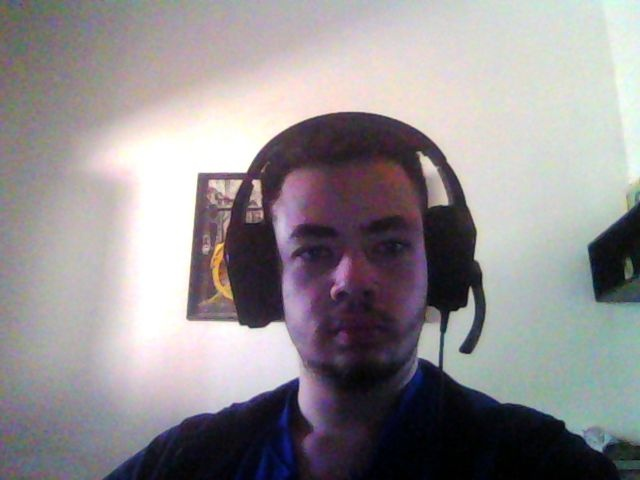

Capturando imagem 3/15...


<IPython.core.display.Javascript object>

Salvo como dataset/Joao_Vitor/2.jpg


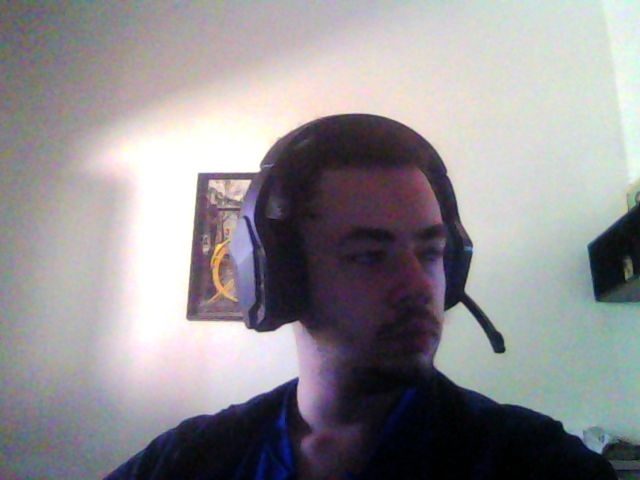

Capturando imagem 4/15...


<IPython.core.display.Javascript object>

Salvo como dataset/Joao_Vitor/3.jpg


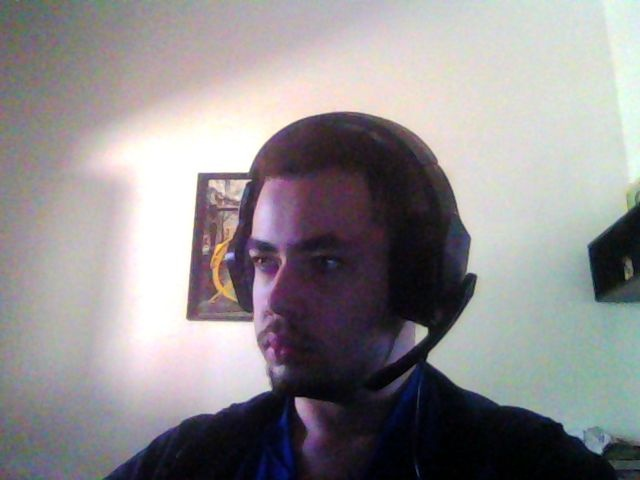

Capturando imagem 5/15...


<IPython.core.display.Javascript object>

Salvo como dataset/Joao_Vitor/4.jpg


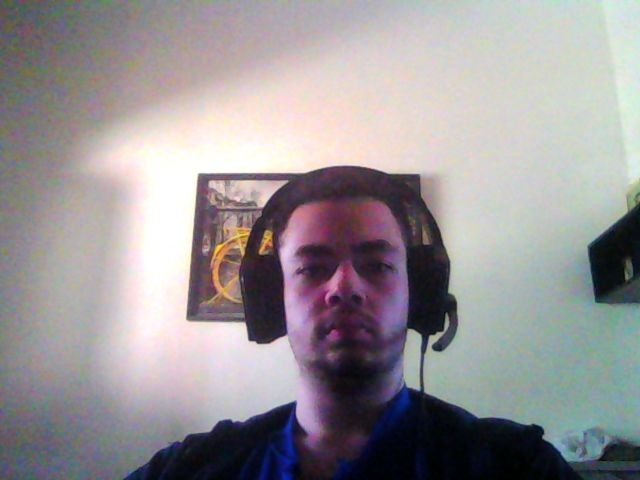

Capturando imagem 6/15...


<IPython.core.display.Javascript object>

Salvo como dataset/Joao_Vitor/5.jpg


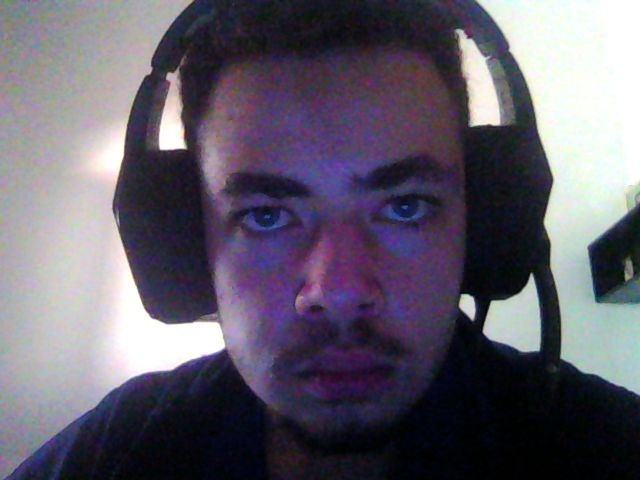

Capturando imagem 7/15...


<IPython.core.display.Javascript object>

Salvo como dataset/Joao_Vitor/6.jpg


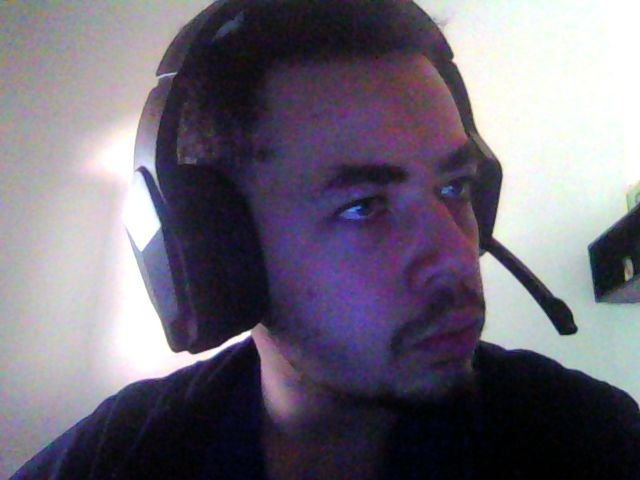

Capturando imagem 8/15...


<IPython.core.display.Javascript object>

Salvo como dataset/Joao_Vitor/7.jpg


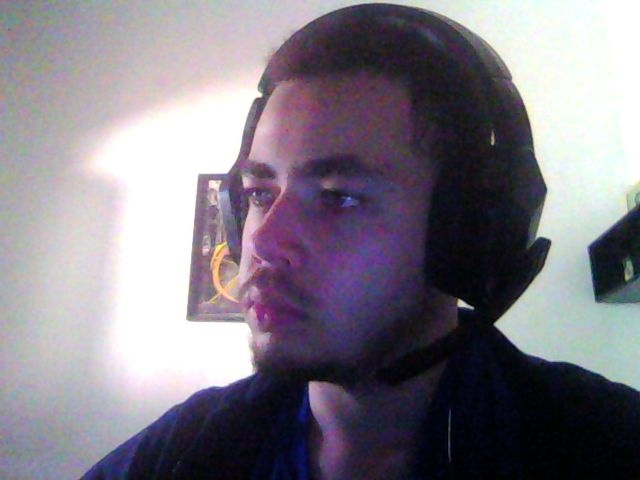

Capturando imagem 9/15...


<IPython.core.display.Javascript object>

Salvo como dataset/Joao_Vitor/8.jpg


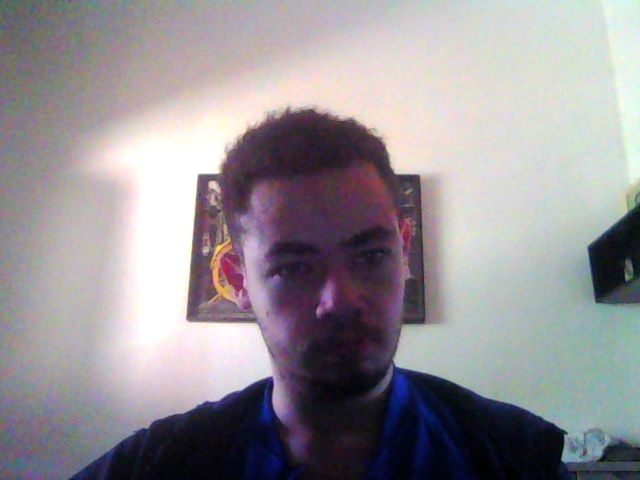

Capturando imagem 10/15...


<IPython.core.display.Javascript object>

Salvo como dataset/Joao_Vitor/9.jpg


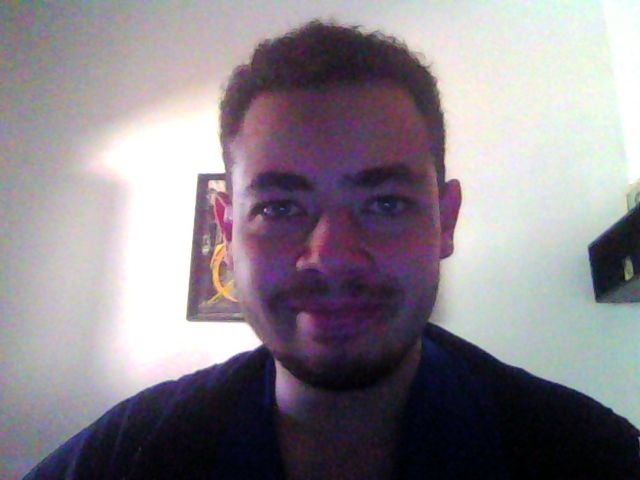

Capturando imagem 11/15...


<IPython.core.display.Javascript object>

Salvo como dataset/Joao_Vitor/10.jpg


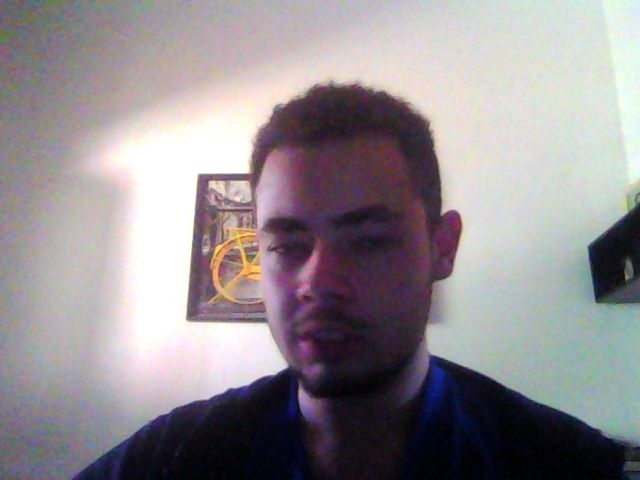

Capturando imagem 12/15...


<IPython.core.display.Javascript object>

Salvo como dataset/Joao_Vitor/11.jpg


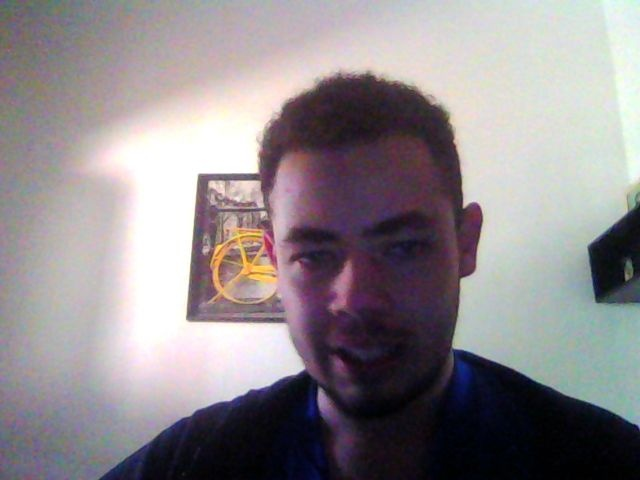

Capturando imagem 13/15...


<IPython.core.display.Javascript object>

Salvo como dataset/Joao_Vitor/12.jpg


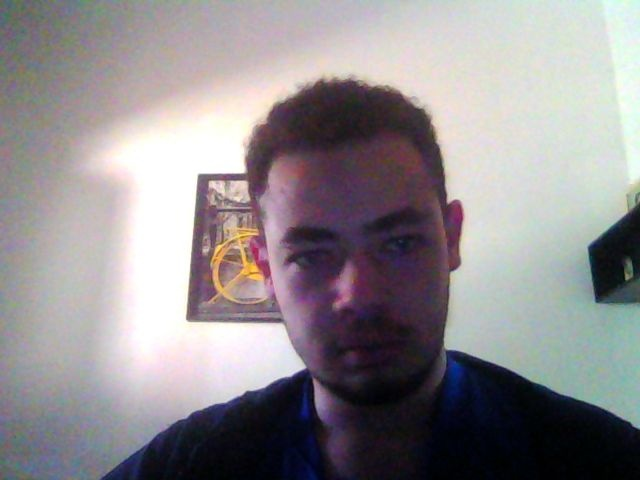

Capturando imagem 14/15...


<IPython.core.display.Javascript object>

Salvo como dataset/Joao_Vitor/13.jpg


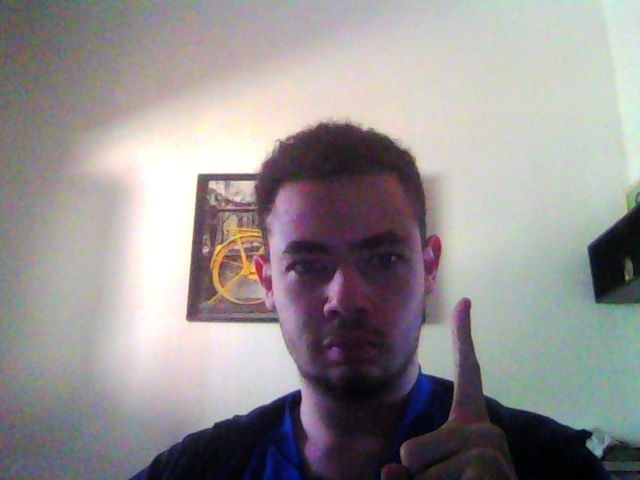

Capturando imagem 15/15...


<IPython.core.display.Javascript object>

Salvo como dataset/Joao_Vitor/14.jpg


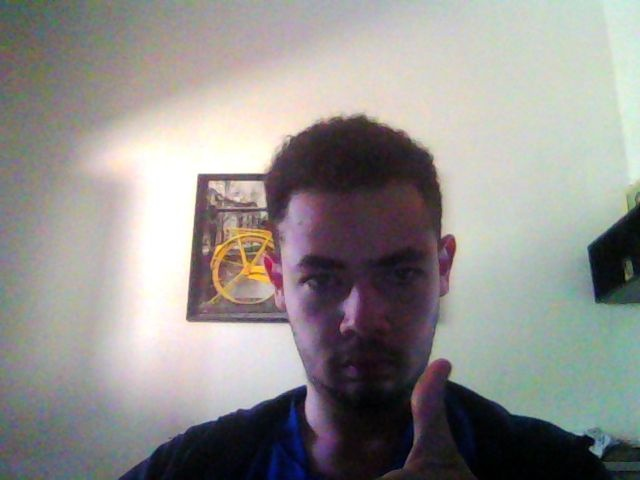


Dataset para 'Joao_Vitor' criado com sucesso!


In [ ]:
# Célula 3: Criar o Dataset

# Nome da pessoa a ser cadastrada
person_name = input("Digite o nome da pessoa a ser cadastrada (sem espaços ou acentos): ")
dataset_path = f"dataset/{person_name}"

# Cria a pasta para a pessoa se não existir
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

# Captura 15 imagens da pessoa
print(f"Prepare-se para tirar 15 fotos de '{person_name}'. Varie as expressões e ângulos.")
for i in range(15):
    print(f"Capturando imagem {i+1}/15...")
    try:
        filename = take_photo(filename=f"{dataset_path}/{i}.jpg")
        print(f"Salvo como {filename}")
        img = cv2.imread(filename)
        cv2_imshow(img) # Mostra a imagem capturada
    except Exception as e:
        print(f"Erro ao capturar imagem: {e}")

print(f"\nDataset para '{person_name}' criado com sucesso!")

In [ ]:
#Treinamento

def get_embedding(model, face_pixels):

    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    samples = np.expand_dims(face_pixels, axis=0)
    yhat = model.predict(samples)
    return yhat[0]


!wget https://github.com/davidsandberg/facenet/raw/master/src/models/20180402-114759/20180402-114759.pb -P model/
!wget https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

!pip install keras-facenet
from keras_facenet import FaceNet
embedder = FaceNet()

detector = MTCNN()
dataset_path = 'dataset/'

embeddings = []
labels = []


for person_folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, person_folder)
    if not os.path.isdir(folder_path):
        continue
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = detector.detect_faces(image_rgb)
        if results:
            x1, y1, width, height = results[0]['box']
            x2, y2 = x1 + width, y1 + height
            face = image_rgb[y1:y2, x1:x2]
            required_size = (160, 160)
            face_resized = cv2.resize(face, required_size)
            embedding = embedder.embeddings([face_resized])[0]
            embeddings.append(embedding)
            labels.append(person_folder)

print(f"Processadas {len(embeddings)} faces.")

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
model = SVC(kernel='linear', probability=True)
model.fit(np.asarray(embeddings), labels_encoded)
with open('face_recognition_model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("\nTreinamento concluído e modelo salvo!")

--2025-07-22 14:35:42--  https://github.com/davidsandberg/facenet/raw/master/src/models/20180402-114759/20180402-114759.pb
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-07-22 14:35:43 ERROR 404: Not Found.

--2025-07-22 14:35:43--  https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/octet-stream]
Saving to: ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5.11’

inception_v3_weight 100%[===================>]  83.84M   303MB/s    in 0.3s    

2025-07-22 14:35:43 (303 MB/s) - ‘inception_

Carregando modelos pré-treinados...
Modelos carregados com sucesso!
Execute esta célula e clique em 'Capturar' para testar.


<IPython.core.display.Javascript object>


Detectado(s) 1 rosto(s). Analisando...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

Exibindo resultado:


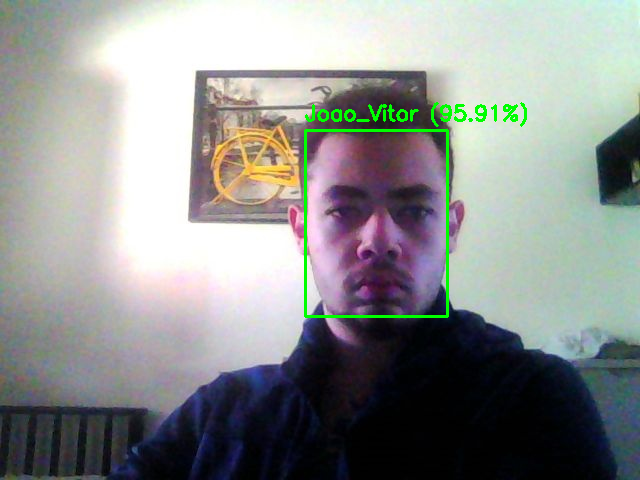

In [ ]:
# Hora de testar (execute e pressione capturar)

from keras_facenet import FaceNet
from mtcnn.mtcnn import MTCNN
import pickle
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

print("Carregando modelos pré-treinados...")
try:
    # Carrega o extrator de embeddings
    embedder = FaceNet()

    # Carrega o classificador SVM treinado
    svm_model = pickle.load(open('face_recognition_model.pkl', 'rb'))

    # Carrega o codificador de nomes
    encoder = pickle.load(open('label_encoder.pkl', 'rb'))

    # Cria o detector de faces
    detector = MTCNN()

    print("Modelos carregados com sucesso!")
    print("Execute esta célula e clique em 'Capturar' para testar.")

except FileNotFoundError:
    print("\nERRO: Arquivos de modelo ('face_recognition_model.pkl' ou 'label_encoder.pkl') não encontrados.")
    print("Por favor, execute a Célula 4 (treinamento) primeiro antes de rodar esta célula.")
except Exception as e:
    print(f"Ocorreu um erro ao carregar os modelos: {e}")


# --- Captura e Reconhecimento ---
try:
    # Tira uma foto com a webcam (função da Célula 2)
    filename = take_photo()

    # Carrega a imagem capturada
    image = cv2.imread(filename)
    if image is None:
        raise FileNotFoundError("Não foi possível ler a imagem capturada.")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detecta faces na imagem
    faces = detector.detect_faces(image_rgb)

    if not faces:
        print("\nNenhum rosto foi detectado na imagem.")
    else:
        print(f"\nDetectado(s) {len(faces)} rosto(s). Analisando...")
        # Itera sobre cada rosto encontrado
        for face_info in faces:
            x1, y1, width, height = face_info['box']
            x2, y2 = x1 + width, y1 + height
            face = image_rgb[y1:y2, x1:x2]
            face_resized = cv2.resize(face, (160, 160))
            embedding = embedder.embeddings([face_resized])[0]
            embedding_para_previsao = embedding.reshape(1, -1)
            prediction = svm_model.predict(embedding_para_previsao)
            probability = svm_model.predict_proba(embedding_para_previsao)
            confidence = np.max(probability) * 100
            person_name = encoder.inverse_transform(prediction)[0]
            if confidence < 65:
                person_name = "Desconhecido"
                label = f"{person_name} ({confidence:.2f}%)"
                color = (0, 0, 255) # Vermelho para desconhecido
            else:
                label = f"{person_name} ({confidence:.2f}%)"
                color = (0, 255, 0) # Verde para conhecido
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    print("\nExibindo resultado:")
    cv2_imshow(image)

except Exception as e:
    print(f"\nOcorreu um erro durante o reconhecimento: {e}")